# Welcome to the Prototype

Table of Contents:
1) **Introduction**<br>
2) **Datasets**<br>
    2.1) Synthetic Dataset<br>
    2.2) 30 Years of European Wind Generation <br>
3) **Transformer Architectures**<br>
    3.1) Informer<br>
    3.2) Autoformer<br>
    3.4) Pyraformer<br>
4) **Forecasting**<br>
    4.1) 24-Hour Windows (Day)<br>
    4.2) 168-Hour Windows (Week)<br>
    4.3) 720-Hour Windows (Month)<br>
5) **Summary**

## **1. Introduction**

In [ ]:
# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
import torch

## **2. Datasets**

### **2.1) Synthetic Data**

Below we generate two synthetic datasets that emulate energy data (consumption, load, etc.) patterns using a linear combination of three sine functions.

The code for the data generator is a slight amendment of the synthetic generator used in [[1]](https://repositum.tuwien.at/handle/20.500.12708/135874).

The equation for the synthetic time series is defined as: 
$$f(t) = \beta_0 = \beta_1 sin(\frac{2\pi}{24}t) + \beta_2 sin(\frac{2\pi}{168}t) + \beta_3 sin(\frac{2\pi}{720}t),$$
where $\beta_1$, $\beta_2$, and $\beta_3$ are uniformly sampled for each point in time $t$ from $[5,10]$, while $\beta_0$ follows a Gaussian process with a polynomially decaying covariance function $\Sigma_{t_1, t_2} = |t_1 - t_2|^{-1}$, where $\Sigma_{t_1} = \Sigma_{t_2} = 1$ and $t_1$ and $t_2$ are arbitrary time stamps.

The synthetic dataset, with the decaying covariance function is supposed to model long-range dependencies over $24$, $168$ and $720$ hour ranges.

At the initial stage, for ease of implementation we will generate two synthetic time series with a sequence length of 17,420 - which is roughly two years of hourly data.

**Important to Note:**
Due to the aforementioned specifications of the data generator, re-running this section will lead to the generation of two new time series, replacing the existing datasets.

In [ ]:
from data_generator import SynthesisTS

In [ ]:
# Initialize data synthesizer
SynthMaker = SynthesisTS(series_amount=1, seq_len=17420)

In [ ]:
# Generate first synthetic time series
df1 = SynthMaker.synthesize_single_series()

The obtained dataset is a univariate time series that comes with arbitrarily picked datatime index, which later gets used in Transformer time series frameworks for time feature embedding.

In [ ]:
df1.head()

,date,TARGET
0,2022-01-25 22:00:00,-14.648879
1,2022-01-25 23:00:00,-11.896418
2,2022-01-26 00:00:00,-10.142491
3,2022-01-26 01:00:00,-8.443276
4,2022-01-26 02:00:00,-5.100413


In [ ]:
# Descriptive statistics
df1.describe()

,TARGET
count,17420.000000
mean,-0.028227
std,8.832361
min,-22.467177
25%,-6.258678
50%,0.045538
75%,6.217201
max,22.536278


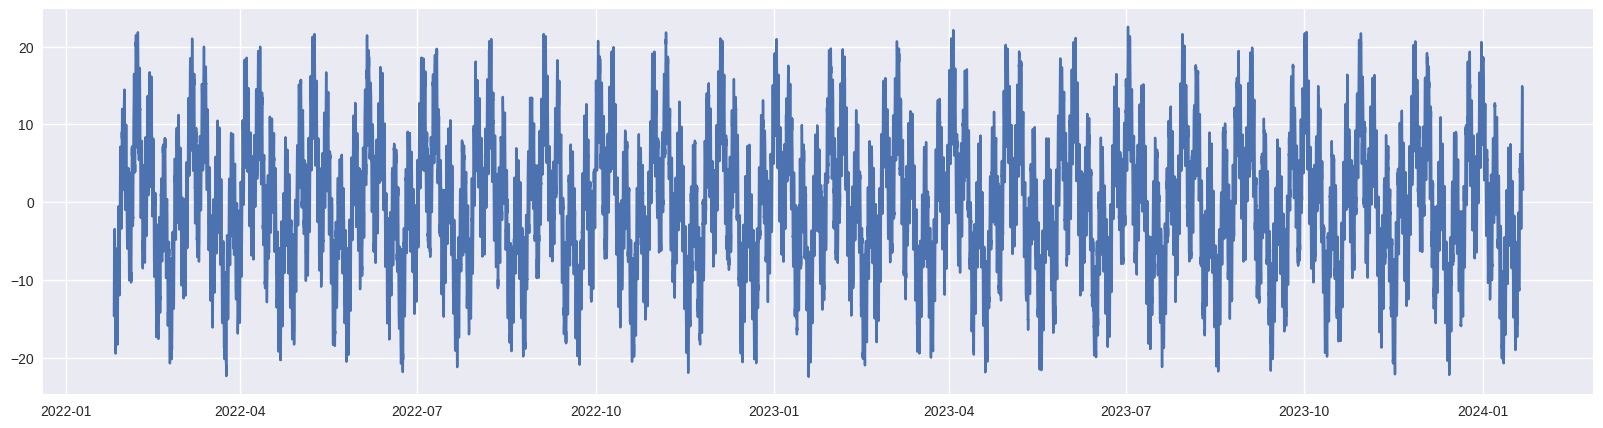

In [ ]:
# Plot
plt.figure(figsize=(20, 5))
plt.plot(df1['date'], df1['TARGET'])
plt.show()

In [ ]:
# Generate second time series
df2 = SynthMaker.synthesize_single_series()

In [ ]:
df2.head()

,date,TARGET
0,2022-01-04 20:00:00,-2.771159
1,2022-01-04 21:00:00,-3.925664
2,2022-01-04 22:00:00,-3.202413
3,2022-01-04 23:00:00,-0.233802
4,2022-01-05 00:00:00,0.627382


In [ ]:
# Descriptive statistics
df2.describe()

,TARGET
count,17420.000000
mean,0.086133
std,9.459860
min,-24.797278
25%,-6.713751
50%,0.120974
75%,6.854593
max,24.699640


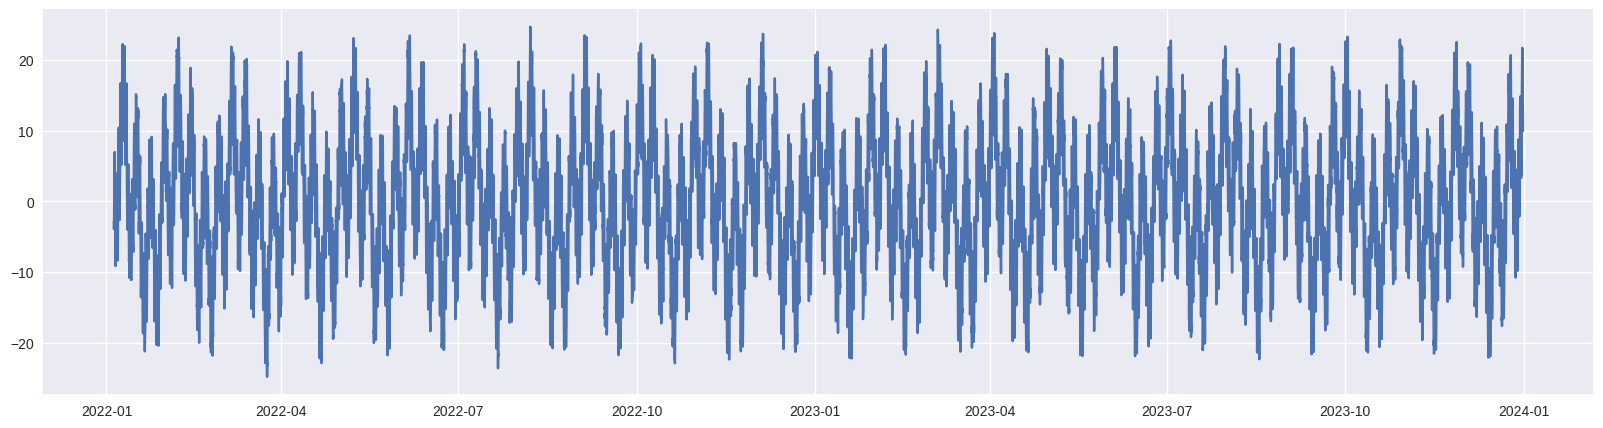

In [ ]:
# Plot
plt.figure(figsize=(20, 5))
plt.plot(df2['date'], df2['TARGET'])
plt.show()

In [ ]:
# Save
df1.to_csv('SYNTHDataset/SYNTHh1.csv', index=False)
df2.to_csv('SYNTHDataset/SYNTHh2.csv', index=False)

### **2.2) 30 Years of European Wind Generation**

## **3. Transformer Architectures**

### **3.1) Informer**

### **3.2) Autoformer**

### **3.4) Pyraformer**

## **4. Forecasting**

### **4.1) 24-Hour Windows (Day)**

### **4.2) 168-Hour Windows (Week)**

### **4.3) 720-Hour Windows (Month)**

## **5. Summary**

[1] S. Liu, H. Yu, C. Liao, J. Li, W. Lin, A. X. Liu, and S. Dustdar, “Pyraformer: Low-Complexity Pyramidal Attention for Long-Range Time Series Modeling and Forecasting,” 2022, publisher: TU Wien. [Online]. Available: https://repositum.tuwien.at/handle/20.500.12708/135874